In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
from IPython import display
import random
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Flatten,  Reshape,Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [3]:
# 이미지 파일의 경로
image_dir = "/content/drive/MyDrive/cloud_ai/18.gan/workspace/celeb_image/"

In [4]:
# image_dataset_from_directory : 디렉토리 (폴더)에서 이미지 파일을 읽어서 리턴

# image_dir : 이미지 파일의 경로
# label_mode=None : 이미지 분류 레이블은 없음
# image_size=(64, 64) : 이미지는 64줄 64칸 사이즈로 사이즈 조정
# batch_size=256 : 한번에 256개 이미지씩 읽어 들임
train_sequence = image_dataset_from_directory(
    image_dir, label_mode=None, image_size=(64, 64), batch_size=256
)

Found 5000 files belonging to 1 classes.


In [5]:
# 이미지 파일의 데이터는 0~255 사이의 정수임
# train_sequence.map(lambda x: (x -127.5)/127.5 ) : 이미지 파일의 데이터 x에서 127.5을 빼고 127.5로 나눠서 -1~1 사이의 값으로 변환
train_sequence = train_sequence.map(lambda x: (x -127.5) / 127.5 )

In [6]:
# 이미지 파일을 X_train에 저장
for index, (X_train) in enumerate(train_sequence):
    # 반복 종료
    break

In [7]:
# 이미지 조회
X_train

<tf.Tensor: shape=(256, 64, 64, 3), dtype=float32, numpy=
array([[[[ 6.54218376e-01,  6.15002692e-01,  5.67943871e-01],
         [ 6.60694301e-01,  6.21478617e-01,  5.74419796e-01],
         [ 6.70588255e-01,  6.31372571e-01,  5.84313750e-01],
         ...,
         [ 5.49387276e-01,  4.70955878e-01,  4.00367647e-01],
         [ 5.34681380e-01,  4.56250012e-01,  3.85661751e-01],
         [ 5.37254930e-01,  4.58823532e-01,  3.80392164e-01]],

        [[ 6.75367653e-01,  6.36151969e-01,  5.89093149e-01],
         [ 6.70588255e-01,  6.31372571e-01,  5.84313750e-01],
         [ 6.64420545e-01,  6.25204861e-01,  5.78146040e-01],
         ...,
         [ 5.49387276e-01,  4.70955878e-01,  4.00367647e-01],
         [ 5.34681380e-01,  4.56250012e-01,  3.85661751e-01],
         [ 5.37254930e-01,  4.58823532e-01,  3.80392164e-01]],

        [[ 6.70588255e-01,  6.31372571e-01,  5.84313750e-01],
         [ 6.70588255e-01,  6.31372571e-01,  5.84313750e-01],
         [ 6.70588255e-01,  6.31372571e-01

In [8]:
X_train.shape

TensorShape([256, 64, 64, 3])

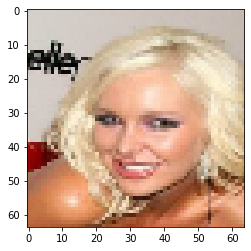

In [9]:
# 이미지 출력

# X_train[0].numpy() * 127.5 + 127.5 : 0번째 이미지를 numpy 배열로 변환 후 127.5 을 곱하고 127.5 더해서 0~255 사이의 실수로 변환
# .astype(np.uint8) : 0~255 사이 정수로 변환
plt.imshow((X_train[0].numpy() * 127.5 + 127.5).astype(np.uint8))

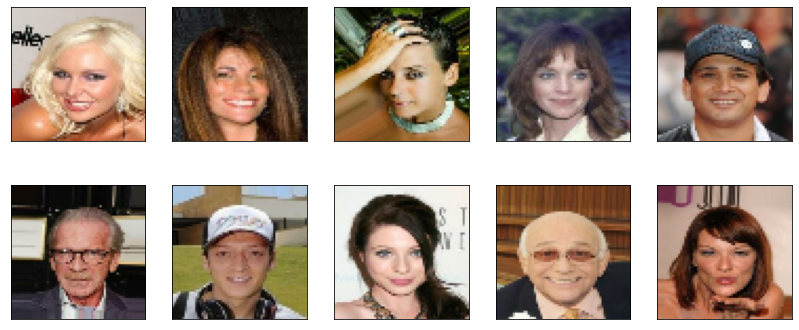

In [10]:
# 5줄의 5칸 가로 14 세로 14 그래프를 그림
fig, axes = plt.subplots(2, 5, figsize = (14,6))

idx = 0
for row in range(2):
    for column in range(5):
        #axes[row, column].imshow : X_train[idx] :를 row 줄 column 칸에 출력
        # (X_train[idx].numpy() * 127.5 + 127.5 : idx 번째 이미지를 numpy 배열로 변환 후 127.5 을 곱하고 127.5 더해서 0~255 사이의 실수로 변환
        # .astype(np.uint8) : 0~255 사이 정수로 변환
        axes[row, column].imshow( (X_train[idx].numpy() *127.5 + 127.5).astype(np.uint8) )
         #x축 좌표가 출력되지 않도록 설정
        axes[row, column].get_xaxis().set_visible(False)
        #y축 좌표가 출력되지 않도록 설정
        axes[row, column].get_yaxis().set_visible(False)
        # idx 1증가
        idx+=1

# 생성자 구현

In [11]:
# 진짜 같은 가짜 이미지를 생성할 생성자 객체 생성
generator = Sequential()

In [12]:
# 128개의 데이터를 입력 받아서 8 * 8 *128번의 선형 회귀실행
generator.add(Dense(8 * 8 * 128, input_dim=128))

In [13]:
# 8 * 8 *128 개의 데이터를 입력 받아서 8줄 128칸 의 데이터 8개로 변환
generator.add(Reshape((8, 8,128)))

In [14]:
# 4줄 4칸 128개의 필터를 2칸씩 합성곱한 이미지를 복원
generator.add ( Conv2DTranspose(128, kernel_size=4, strides=2, padding="same") )

In [15]:
# 0.2 미만의 값을 0,2로 리턴 0.2 이상의 값은 해당 값을 리턴
generator.add ( LeakyReLU(alpha=0.2))

In [16]:
# 4줄 4칸 256개의 필터를 2칸씩 합성곱한 이미지를 복원
generator.add ( Conv2DTranspose(256, kernel_size=4, strides=2, padding="same") )

In [17]:
# 0.2 미만의 값을 0,2로 리턴 0.2 이상의 값은 해당 값을 리턴
generator.add ( LeakyReLU(alpha=0.2) )

In [18]:
# 4줄 4칸 512개의 필터를 2칸씩 합성곱한 이미지를 복원
generator.add ( Conv2DTranspose(512, kernel_size=4, strides=2, padding="same") )

In [19]:
# 0.2 미만의 값을 0,2로 리턴 0.2 이상의 값은 해당 값을 리턴
generator.add ( LeakyReLU(alpha=0.2) )

In [20]:
# 5줄 5칸 3개의 필터를 2칸씩 합성곱한 이미지를 복원
# 활성함수는 tanh를 사용해서 -1~1 사이의 값을 리턴
generator.add ( Conv2D(3, kernel_size=5, padding="same", activation="tanh") )

In [21]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 256)       0

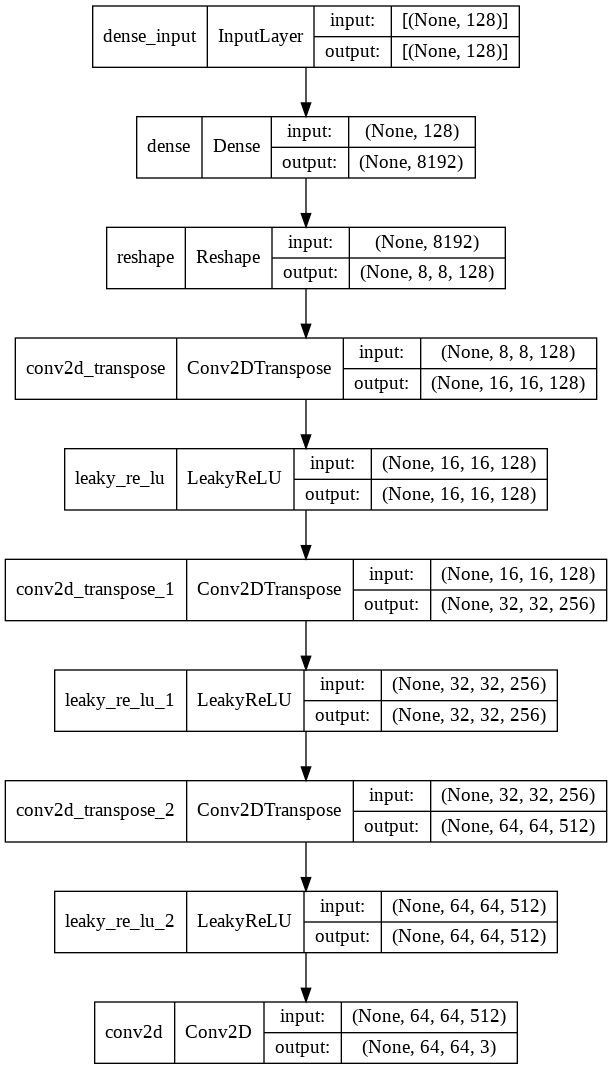

In [22]:
from tensorflow.keras.utils  import plot_model
plot_model(generator, show_shapes=True)

In [23]:
# random한 값을 가진 1줄 128칸 이미지 1개 생성
new_image = tf.random.normal([1, 128])

In [24]:
new_image

<tf.Tensor: shape=(1, 128), dtype=float32, numpy=
array([[ 0.22598897,  0.43665656,  1.3982018 , -0.26873165, -0.0340379 ,
        -0.32308587,  0.7746698 , -0.20053983,  0.20564167,  0.14223437,
         1.6013966 ,  0.13149947,  0.5773165 ,  0.81601036, -0.1851155 ,
        -0.18536445, -0.94723886, -1.7650136 , -0.17405127, -0.59611285,
         1.6764255 , -0.00406834, -0.54084665, -0.63659924, -0.8338509 ,
         1.9457215 ,  0.43704152, -1.4284757 , -1.8476602 , -1.1101365 ,
         1.0917181 , -0.84801453, -0.80714417,  1.1252404 , -1.3496618 ,
         1.1571321 , -0.24675474, -0.18014657,  0.16056336,  0.87357897,
        -0.65598583, -0.25014147, -0.56187004,  0.44049618, -1.2914648 ,
        -0.05601975, -0.12078544,  0.1425729 , -0.12623817,  0.28690615,
        -1.5934193 ,  1.3411807 , -0.31147432,  1.5038475 ,  0.46818122,
        -0.4495847 , -1.0695354 , -0.6015367 ,  1.9710966 ,  0.4822003 ,
         0.8536459 ,  0.9242939 ,  1.5910645 , -0.27961642, -1.1434699 ,
 

In [25]:
new_image.shape

TensorShape([1, 128])

In [26]:
# new_image를 입력으로 진짜 같은 가짜 이미지 생성 (학습이 아직 않되서 진짜 같지는 않음)
generated_image = generator(new_image, training=False)

In [27]:
generated_image

<tf.Tensor: shape=(1, 64, 64, 3), dtype=float32, numpy=
array([[[[ 1.3796492e-03, -9.6809253e-04,  6.8202848e-05],
         [-1.9264104e-03,  2.2967691e-03, -1.5150617e-03],
         [-1.7748167e-03,  2.1634125e-03,  5.5224514e-03],
         ...,
         [-5.5966596e-03,  8.9159218e-04, -2.0013920e-03],
         [-4.1092108e-03,  3.5725904e-03, -2.3403284e-03],
         [ 1.0196425e-03,  2.4941191e-03,  2.3800938e-03]],

        [[-3.6324044e-03,  1.4785993e-03,  4.9974571e-04],
         [-2.5969036e-03,  1.0603016e-03, -1.2542672e-03],
         [-1.0102971e-03,  7.3489640e-04, -5.8778091e-03],
         ...,
         [ 2.7873318e-03,  4.7919541e-03, -5.8761640e-03],
         [ 1.9164803e-03,  1.0838436e-03, -1.9029870e-03],
         [ 6.1792787e-05,  9.3337859e-04, -3.1927938e-04]],

        [[-1.7421762e-03,  4.8720837e-03, -5.7173584e-04],
         [-4.5903483e-03,  3.4080476e-03, -4.1927914e-03],
         [-4.7298963e-03,  4.4331024e-03, -7.1519904e-04],
         ...,
         [-7.

In [28]:
generated_image.shape

TensorShape([1, 64, 64, 3])

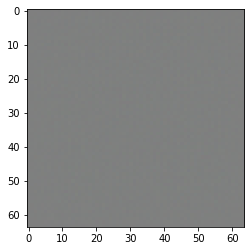

In [29]:
# 생성한 이미지 출력(진짜 같은 이미지를 생성하는게 목표, 학습전이라 아직 진짜 같지는 않음)

# (generated_image[0].numpy() * 127.5 + 127.5 : 생성한 0번째 이미지를 numpy 배열로 변환 후 127.5 을 곱하고 127.5 더해서 0~255 사이의 실수로 변환
# .astype(np.uint8) : 0~255 사이 정수로 변환
plt.imshow( (generated_image[0] .numpy() *127.5+127.5).astype(np.uint8) )

# 판별자

In [30]:
# 가짜 이미지는 0 진짜 이미지는 1로 판별하는 판별자 생성
discriminator = tf.keras.Sequential()

In [31]:
# input_shape=(64,64,3) : 64줄 64칸의 컬러 이미지를 입력 받음
# 4줄 4칸 64개의 필터를 2칸씩 합성곱
discriminator.add( Conv2D(64, kernel_size=4, strides=2, padding="same", input_shape=(64,64,3) ) )

In [32]:
# 0.2 미만의 값을 0,2로 리턴 0.2 이상의 값은 해당 값을 리턴
discriminator.add( LeakyReLU(alpha=0.2) )

In [33]:
# 4줄 4칸 128개의 필터를 2칸씩 합성곱
discriminator.add( Conv2D(128, kernel_size=4, strides=2, padding="same") )

In [34]:
# 0.2 미만의 값을 0,2로 리턴 0.2 이상의 값은 해당 값을 리턴
discriminator.add( LeakyReLU(alpha=0.2) )

In [35]:
# 4줄 4칸 256개의 필터를 2칸씩 합성곱
discriminator.add( Conv2D(256, kernel_size=4, strides=2, padding="same") )

In [36]:
# 0.2 미만의 값을 0,2로 리턴 0.2 이상의 값은 해당 값을 리턴
discriminator.add( LeakyReLU(alpha=0.2) )

In [37]:
# 연산결과를 1차원으로 변환
discriminator.add( Flatten() )

In [38]:
# weight와 bias중에서 20%는 기울기를 갱신하지 않음
discriminator.add( Dropout(0.2) )

In [39]:
# 1번 선형회귀 활성함수 sigmoid를 실행해 0~1 사이의 값을 리턴
discriminator.add( Dense(1, activation="sigmoid") )

In [40]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 256)         524544    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8, 8, 256)         0         
                                                                 
 flatten (Flatten)           (None, 16384)            

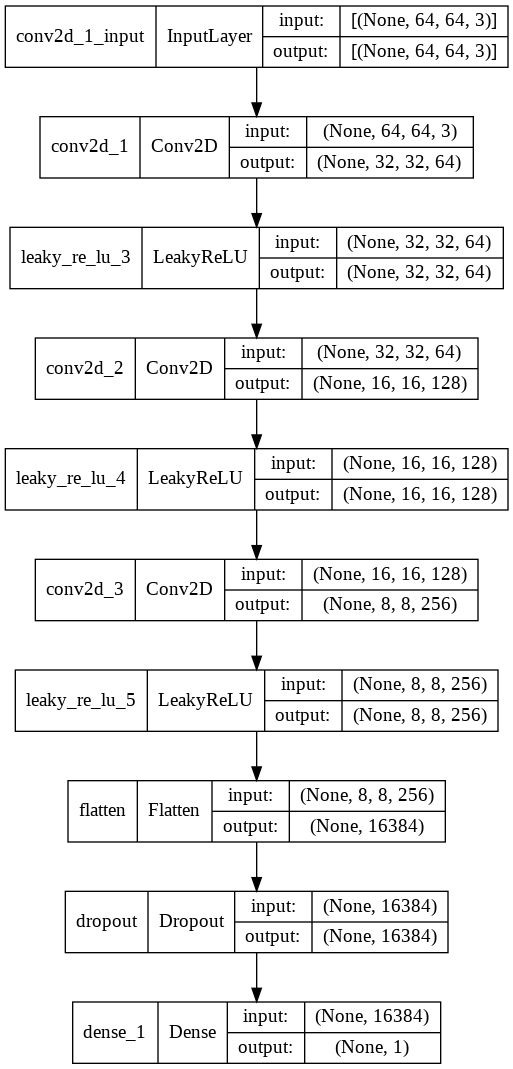

In [41]:
from tensorflow.keras.utils  import plot_model
plot_model(discriminator, show_shapes=True)

In [42]:
# 생성한 가짜 이미지 (generated_image) 를 진짜이미지 인지 생성한 가짜 이미지인지 판별
# 진짜 이미지 1, 가짜 이미지 0
decision = discriminator(generated_image)

In [43]:
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.500056]], dtype=float32)>

In [44]:
# 진짜 이미지 0 가짜 이미지 1 
# 2가지로 분류할떼 loss를 계산할 객체 생성

cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [45]:
# 생성자 옵티마이져 객체
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [46]:
# 판별자 옵티 마이져 객체
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [47]:
# 반복 횟수
EPOCHS = 1000

In [48]:
# 입력값의 칸수의 
noise_dim = 128

In [49]:
# 입력 데이터 줄의 개수 (10줄)
num_examples_to_generate = 10

In [50]:
# 생성 모델의 입력 10줄 128칸
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [51]:
# 한번에 256개씩 가짜 이미지 생성
BATCH_SIZE = 256

In [52]:
for epoch in range(EPOCHS):
    # train_dataset이 256개씩 X_train 이미지를 리턴해서 image_batch에 저장
    for image_batch in train_sequence:
        # batch_size개의 28줄 28칸의 랜덤함 값의 이미지를 생성
        # 이 이미지를 입력으로 생성 모델이 진짜같은 이미지를 생성할 것임  
        noise = tf.random.normal([BATCH_SIZE, noise_dim])
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            #noise를 입력으로 진짜 같은 이미지 생성
            generated_images = generator(noise, training=True)
            # 진짜 이미지 image_batch를 dicriminator가 판별 
            # 진짜 1 가짜 0으로 판별 
            real_output = discriminator(image_batch, training=True)
            # 가짜 이미지 generated_image를 dicriminator가 판별 
            # 진짜 1 가짜 0으로 판별
            fake_output = discriminator(generated_images, training=True)

            #생성자의 cost (loss)
            # tf.ones_like(fake_output) : 가짜 이미지 fake_output 개수만큼 1이 저장된배열생성  
            
            # cross_entropy(a,b) : a와 b가 다른 비율 계산
            
            # a는 tf.ones_like(fake_output)
            # b는 fake_output (가짜 이미지 판별 결과 가짜 0 진짜 1)
            # 이므로 generator_loss는 판별자가 가짜 이미지를 모두 진짜로 판별하면 0
            # 가짜 이미지를 모두 가짜로 올바르게 판별하면 무한대의 오차값을 리턴
            
            # 딥러닝은 loss가 작아지게 학습하기 때문에 판별자가 가짜 이미지를 진짜로 판별하도록
            # 생성자는 진짜 같은 이미지를 생성하도록 학습됨
            generator_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
                
            
            # 판별자의 cost (loss)
            #f.ones_like(real_output) : 진짜 이미지 real_output 개수만큼 1이 저장된배열생성 
            # cross_entropy(a,b) : a와 b가 다른 비율 계산
            
            # a는 tf.one_like(real_output)
            # b는 real_output (진짜 이미지 판별 결과 가짜라고 생각되면 0 진짜 1)
            # 이므로 real_loss는 판별자가 진짜 이미지를 모두 진짜 1로 판별하면 0
            # 진짜 이미지를 모두 가짜로 잘못 판별하면 무한대의 오차값을 리턴
            
            # 딥러닝은 loss가 작아지게 학습하기 때문에 판별자가 진짜 이미지를 진짜로 판별하도록
            # 판별자는 학습됨
            real_loss = cross_entropy(tf.ones_like(real_output), real_output)
            
            #f.zero_like(fake_output) : 가짜 이미지 fake_output 개수만큼 0이 저장된배열생성 
            # cross_entropy(a,b) : a와 b가 다른 비율 계산
            
            # a는 tf.zero_like(fake_output)
            # b는 fake_output (가짜 이미지 판별 결과 가짜라고 생각되면 0 진짜 1)
            # 이므로 fake_loss는 판별자가 가짜 이미지를 모두 가짜 0으로 판별하면 0
            # 가짜 이미지를 모두 진짜로 잘못 판별하면 무한대의 오차값을 리턴
            
            # 딥러닝은 loss가 작아지게 학습하기 때문에 판별자가 가짜 이미지를 가짜로 판별하도록
            # 판별자는 학습됨
            fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
            #real_loss (진짜를 진짜로 판별한 비율)+ fake_loss (가짜를 가짜로 판별한 비율)
            discriminator_loss = real_loss + fake_loss

            # 생성자 기울기 계산
            gradients_of_generator = gen_tape.gradient(generator_loss, generator.trainable_variables)
            # 판별자 기울기 계산
            gradients_of_discriminator = disc_tape.gradient(discriminator_loss, discriminator.trainable_variables)
            
            #생성자 업데이트
            generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
            # 판별자 업데이트
            discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


        
    # 100 에포크가 지날 때마다 출력.
    if (epoch == 0) or ( (epoch + 1) % 100 == 0) :
        print("="*100)
        print("epoch = ", epoch)
        #real_loss : 진짜를 가짜로 잘못 판별한 비율
        #fake_loss : 가짜를 진짜로 잘못 판별한 비율
        # generator_loss : 판별자를 속인 비율
        print("[D real_loss:%f,fake_loss :%f] [G loss:%f]"%(real_loss, fake_loss, generator_loss))
        print("="*100)
        #seed를 입력으로 가짜 이미지 10개 생성해서 predictions에 저장
        predictions = generator(seed, training=False)
        
        # 5줄의 5칸 가로 14 세로 14 그래프를 그림
        fig, axes = plt.subplots(2, 5, figsize = (14, 6))

        idx = 0
        for row in range(2):
            for column in range(5):
                # 
                #axes[row, column].imshow : X_train[idx] :생성 이미지 predictions[idx] 를 row 줄 column 칸에 출력
                # (predictions[idx].numpy() * 127.5 + 127.5 : idx 번째 생성 이미지를 numpy 배열로 변환 후 127.5 을 곱하고 127.5 더해서 0~255 사이의 실수로 변환
                # .astype(np.uint8) : 0~255 사이 정수로 변환
                axes[row, column].imshow( (predictions[idx].numpy() * 127.5 + 127.5).astype(np.uint8))
                #x축 좌표가 출력되지 않도록 설정
                axes[row, column].get_xaxis().set_visible(False)
                #y축 좌표가 출력되지 않도록 설정
                axes[row, column].get_yaxis().set_visible(False)
                # idx 1증가
                idx+=1

        plt.show()
    


Output hidden; open in https://colab.research.google.com to view.

In [53]:
generator.save("/content/drive/MyDrive/cloud_ai/18.gan/workspace/face_gan_generator.h5")

In [54]:
discriminator.save("/content/drive/MyDrive/cloud_ai/18.gan/workspace/face_gan_discriminator.h5")